In [2]:
import pandas as pd
from sklearn.neighbors import kneighbors_graph

import random
import numpy as np 

import networkx as nx
import matplotlib.pyplot as plt

import math 
from tqdm.notebook import tqdm

import sklearn.metrics as metrics


In [3]:
# Dataset_Name: arsenic_nov2001.txt
# 20,043 arsenic samples from potable ground water,
# retrieved from the USGS National Water Information System in 2001
#
# This dataset is a product of the U.S. Geological Survey's
# National Water-Quality Assessment (NAWQA) program.
#
# Data_Format: TAB-delimited ASCII text
# World_Wide_Web_URL: http://water.usgs.gov/nawqa/trace/data/arsenic_nov2001.txt
#
# Citation:
#   Updated from:
#   Focazio, M.J., Welch, A.H., Watkins, S.A., Helsel, D.R., and Horn, M.A.,
#   1999, A retrospective analysis on the occurrence of arsenic in ground-
#   water resources of the United States and limitations in drinking-water-
#   supply characterizations: U.S. Geological Survey Water-Resources
#   Investigations Report 99-4279, 21 p. 
#
# Spatial_Domain: USA, including Alaska, Hawaii, and Puerto Rico
# Time_Period_of_Content: 1973-2001 (most recent sample for each well)
# Point_of_Contact: Email_Address: traceweb@usgs.gov
#
# Abstract:
#   This dataset is intended to represent the potable ground-water resource.
#   This dataset therefore does not include thermal and saline water
#   (temperature greater than 50 degrees C or dissolved solids greater than
#   3000 mg/L or specific conductance greater than 4000 uS/cm).  In addition,
#   this dataset includes only the most recent arsenic analysis available
#   for each well, and only analyses performed by hydride generation or ICP/MS.
#
# Basic documentation of dataset elements:
# STAID:    USGS station identifier, based on latitude and longitude
#           (each well in the National Water Information System
#           has an unique USGS station identifier)
# STATE:    Two-letter postal code for the U.S. state in which the sample
#           was collected.
# FIPS:     Federal Information Processing Standard state and county codes
#           (see http://www.itl.nist.gov/fipspubs/fip6-4.htm )
# LAT_DMS:  Latitude of well, in degrees, minutes, and seconds
# LONG_DMS: Longitude of well, in degrees, minutes, and seconds
# WELLDPTH: Depth (below land surface) of finished well (may be
#           less than total hole depth drilled) (feet)
# SAMPDATE: Date water sample was collected
# SAMPTIME: Time water sample was collected
# AS_RMRK:  Remark code qualifying the analytical result in AS_CONC.
#           For example, the combination of AS_RMRK="<" and AS_CONC="1"
#           indicates that arsenic was not detectable at a laboratory
#           reporting limit of 1 microgram per liter.
# AS_CONC:  Concentration of arsenic in sample, in micrograms per liter
#           (ug/L) as arsenic
# LAT_DD:   Latitude of well, in decimal degrees
# LON_DD:   Longitude of well, in decimal degrees
#
# --------------------------------------------------------------------------
#   Metadata_Date:    24NOV2001 (Modifed 20FEB2007)
#   Metadata_Contact: traceweb@usgs.gov
# --------------------------------------------------------------------------
#

In [4]:
df = pd.read_csv('/Users/praga/Library/CloudStorage/OneDrive-UniversityofMiami/Research ideas/anomalies in graphs/arsenic_nov2001.txt', delimiter = "\t")

In [5]:
df = df.drop([0])

In [6]:
df.head()

,STAID,STATE,FIPS,LAT_DMS,LON_DMS,WELLDPTH,SAMPDATE,SAMPTIME,AS_RMRK,AS_CONC,LAT_DD,LON_DD
1,182113064451900,VI,78020.0,182113.0,644519.0,100.0,31-Aug-92,1020,<,1.0,18.35361,64.75528
2,182109064460300,VI,78020.0,182109.0,644603.0,60.0,26-Aug-92,1130,<,1.0,18.35250,64.76750
3,180859065474100,PR,72069.0,180859.0,654741.0,NaN,07-Jul-82,940,<,1.0,18.14972,65.79472
4,180339065523300,PR,72151.0,180339.0,655233.0,120.0,07-Jul-82,1645,<,1.0,18.06083,65.87583
5,175836066021400,PR,72015.0,175836.0,660214.0,NaN,12-Aug-86,1545,<,1.0,17.97667,66.03722


In [7]:
df.columns

Index(['STAID', 'STATE', 'FIPS', 'LAT_DMS ', ' LON_DMS', 'WELLDPTH  ',
       'SAMPDATE ', 'SAMPTIME', 'AS_RMRK', 'AS_CONC', 'LAT_DD', 'LON_DD'],
      dtype='object')

In [8]:
df['SAMPDATE ']

1        31-Aug-92
2        26-Aug-92
3        07-Jul-82
4        07-Jul-82
5        12-Aug-86
           ...    
20039    27-Jun-79
20040    27-Jun-79
20041    28-Jun-79
20042    28-Jun-79
20043    05-Jun-79
Name: SAMPDATE , Length: 20043, dtype: object

In [9]:
df_org = df.dropna()

In [10]:
df_org_idaho = df_org[df_org.STATE == 'ID']  #select only wells from idaho

unique_st_id = df_org_idaho.STAID.unique()
len(unique_st_id)

sub_sample_id_count = 219
selected_st_ids = random.sample(sorted(unique_st_id), sub_sample_id_count)

df = df_org_idaho[df_org_idaho['STAID'].isin(selected_st_ids)]

In [11]:
df.head()

,STAID,STATE,FIPS,LAT_DMS,LON_DMS,WELLDPTH,SAMPDATE,SAMPTIME,AS_RMRK,AS_CONC,LAT_DD,LON_DD
12467,420834111073701,ID,16007.0,420834.0,1110737.0,38.0,17-Aug-96,1625,<,1.0,42.14278,111.12695
12509,434410111150001,ID,16081.0,434410.0,1111500.0,180.0,09-Aug-96,1320,<,1.0,43.73611,111.25000
12518,421246111162901,ID,16007.0,421246.0,1111629.0,40.0,14-Aug-93,1600,<,1.0,42.21278,111.27472
12725,440853111353601,ID,16043.0,440853.0,1113536.0,175.0,05-Aug-96,1215,<,1.0,44.14805,111.59333
12746,423848111372801,ID,16029.0,423848.0,1113728.0,77.0,27-Jun-96,1700,.,2.0,42.64667,111.62444


In [12]:
df_org.STATE.value_counts()

ID    1935
CA    1816
NJ    1328
WA     980
AZ     613
CO     528
NV     504
TX     443
FL     414
MD     384
PA     358
NM     344
NE     341
TN     341
SD     333
LA     287
OK     272
MO     250
WI     243
UT     234
IN     233
OH     229
NH     225
CT     188
OR     181
ND     176
MI     175
MA     164
AK     153
KS     148
MT     148
WV     138
AL     130
AR     117
DE     110
WY     106
IA      89
NC      87
IL      86
VA      78
MN      77
GA      77
MS      41
NY      36
PR      31
SC      24
ME      23
KY      15
RI       5
VT       4
VI       2
Name: STATE, dtype: int64

In [13]:
df.shape

(219, 12)

In [14]:
df[df.STAID==selected_st_ids[5]]

,STAID,STATE,FIPS,LAT_DMS,LON_DMS,WELLDPTH,SAMPDATE,SAMPTIME,AS_RMRK,AS_CONC,LAT_DD,LON_DD
15290,433704116142601,ID,16001.0,433704.0,1161426.0,670.0,20-Oct-93,950,<,1.0,43.61777,116.24055


In [15]:
### convert the AS_RMRK column 

df.AS_RMRK.value_counts()

.    166
<     44
-      9
Name: AS_RMRK, dtype: int64

In [16]:
df = df.replace({"<":0, ".":1, "-":2})

### generate KNN graph 

In [17]:
df.head()

,STAID,STATE,FIPS,LAT_DMS,LON_DMS,WELLDPTH,SAMPDATE,SAMPTIME,AS_RMRK,AS_CONC,LAT_DD,LON_DD
12467,420834111073701,ID,16007.0,420834.0,1110737.0,38.0,17-Aug-96,1625,0,1.0,42.14278,111.12695
12509,434410111150001,ID,16081.0,434410.0,1111500.0,180.0,09-Aug-96,1320,0,1.0,43.73611,111.25000
12518,421246111162901,ID,16007.0,421246.0,1111629.0,40.0,14-Aug-93,1600,0,1.0,42.21278,111.27472
12725,440853111353601,ID,16043.0,440853.0,1113536.0,175.0,05-Aug-96,1215,0,1.0,44.14805,111.59333
12746,423848111372801,ID,16029.0,423848.0,1113728.0,77.0,27-Jun-96,1700,1,2.0,42.64667,111.62444


In [18]:
df.dtypes

STAID          object
STATE          object
FIPS          float64
LAT_DMS       float64
 LON_DMS      float64
WELLDPTH      float64
SAMPDATE       object
SAMPTIME       object
AS_RMRK         int64
AS_CONC       float64
LAT_DD        float64
LON_DD        float64
dtype: object

In [19]:
df = df.drop(['STATE', 'SAMPDATE ', 'SAMPTIME'], axis=1)

In [20]:
Y = df['AS_CONC'].to_numpy()
Y = Y.reshape(-1,1)
Y.shape

(219, 1)

In [21]:
df['AS_CONC'].mean()

7.2465753424657535

## select the data 

In [22]:
df_NN = df[['LAT_DD', 'LON_DD']]
df_NN.head()

# this is the part where we select the data process - select one of the following
#df_y = df[['AS_CONC']]
df_y = df_NN

In [23]:
neighbour_count = 8

Adj = kneighbors_graph(df_NN, neighbour_count,  mode='connectivity', include_self=False)

## since kneighbors from scikit learn used a digraph we will always get non symmetric matrix, hence lets force it to and undirected case 
Adj = Adj + Adj.T
Adj[Adj > 1] = 1

In [24]:
Adj.toarray().shape

(219, 219)

In [25]:
W = Adj.toarray()

In [26]:
W

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [27]:
D = np.diagflat(Adj.sum(axis=1))

In [28]:
D

matrix([[8., 0., 0., ..., 0., 0., 0.],
        [0., 8., 0., ..., 0., 0., 0.],
        [0., 0., 8., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 8., 0., 0.],
        [0., 0., 0., ..., 0., 8., 0.],
        [0., 0., 0., ..., 0., 0., 9.]])

In [29]:
combinatorial_laplacian = D - Adj

In [30]:
eig_val, eig_vec = np.linalg.eig(combinatorial_laplacian)

idx = eig_val.argsort()[::1]   
eig_val = eig_val[idx]
eig_vec = eig_vec[:,idx]

In [31]:
(combinatorial_laplacian ==combinatorial_laplacian.T).all()

True

In [32]:
eig_val

array([-2.10595430e-15,  1.42589165e-02,  8.13438258e-02,  1.18145290e-01,
        1.60996707e-01,  2.69099537e-01,  3.33200386e-01,  7.70707318e-01,
        8.12677274e-01,  9.42493613e-01,  1.02570792e+00,  1.21479899e+00,
        1.53100698e+00,  1.90229545e+00,  2.22109997e+00,  2.91215249e+00,
        2.98054883e+00,  3.80653712e+00,  3.95442705e+00,  4.04502443e+00,
        4.41393438e+00,  4.62888218e+00,  4.67455448e+00,  5.08994511e+00,
        5.82448059e+00,  5.94167544e+00,  6.03724537e+00,  6.32889233e+00,
        6.39316777e+00,  6.45109266e+00,  6.88607240e+00,  7.23465936e+00,
        7.23884159e+00,  7.38306564e+00,  7.59047292e+00,  7.75448006e+00,
        7.96464626e+00,  8.03578584e+00,  8.10707101e+00,  8.15948191e+00,
        8.28452202e+00,  8.29950557e+00,  8.33212979e+00,  8.33863961e+00,
        8.39691776e+00,  8.49437193e+00,  8.51049634e+00,  8.60235558e+00,
        8.66004860e+00,  8.66538268e+00,  8.70533848e+00,  8.76971789e+00,
        8.81056224e+00,  

In [33]:
U_transpose = eig_vec.T

rho = eig_val[math.floor(sub_sample_id_count*0.05)] # smallest 96 eigen value 

In [34]:
rho

1.0257079182804452

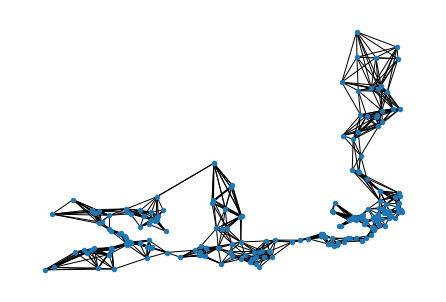

In [35]:
df_NN = df_NN.reset_index(drop=True)

G = nx.Graph(Adj)
cordinates = {node:(df.iloc[node].LON_DD, df.iloc[node].LAT_DD) for node in G.nodes}
nx.draw(G, pos=cordinates, node_size=20)

In [36]:
nx.is_connected(G)

True

## calculate Graph fourier scan statistic (GFSS)

In [37]:
def h_function(lambda_value, rho): 
    return min(1, math.sqrt(abs(rho/lambda_value)))

def critial_snr(lambda_value, rho):
    return min(1, (abs(rho/lambda_value))**2)

def H0_calc(lambda_value, rho, alpha = 0.2):
    return min(1, (abs(rho/lambda_value))**2)*np.log(1/alpha)

def H1_calc(lambda_value, rho, gamma = 0.2):
    return min(1, (abs(rho/lambda_value))**2)*np.log(2/gamma)

In [38]:
ALPHA = 0.1
GAMMA = 0.3


In [39]:
eig_val_intrest = eig_val[1:]
eig_vector_intrest = eig_vec[:,1:]
U_transpose_intrest = eig_vector_intrest.T

G_total = 0
att_bias = 0 
H0_val, H1_val = 0,0
SNR_critical = 0 

for lambda_count in range(len(eig_val_intrest)):
    lambda_value = eig_val_intrest[lambda_count]

    G_val = (h_function(lambda_value, rho)*(eig_vector_intrest[:,lambda_count].T * Y).item()) * eig_vector_intrest[:,lambda_count]

    att_bias += (h_function(lambda_value, rho))**2

    G_total += G_val

    ## corollary 6 : the GFSS (t_bar) can asymptotically distinguish H0 from H1 if the SNR is stronger than below
    SNR_critical += critial_snr(lambda_value, rho)

    H0_val += H0_calc(lambda_value, rho, alpha = ALPHA)
    H1_val += H1_calc(lambda_value, rho, gamma = GAMMA)

# L2 norm - this is the t_bar
attenuated_signal = np.linalg.norm(G_total) - att_bias

# Fourier transform 
F_y = U_transpose_intrest*Y

# cororllary 6 : to fetch mu_sigma ratio 
omega = neighbour_count
mu_sigma_ratio = omega*SNR_critical**(1/4)

#final H0, H1 cal
H0_final = 2*(np.sqrt(H0_val) + np.log(1/ALPHA))
H1_final = (1/2)*((mu_sigma_ratio)**2)- 2*(mu_sigma_ratio)*np.sqrt(np.log(2/GAMMA))- 2*(np.sqrt(H1_val))

print("The value of T_bar : ", attenuated_signal)
print("H0 hypothesis significance : ", H0_final)
print("H1 hypothesis significance : ", H1_final)

The value of T_bar :  79.97751142862046
H0 hypothesis significance :  16.041309394435523
H1 hypothesis significance :  67.42426264182282


In [40]:
attenuated_signal

79.97751142862046

In [41]:
F_y

matrix([[-2.01571850e+01],
        [-5.27646894e+01],
        [ 6.40126381e+00],
        [ 1.54013560e+01],
        [-2.16632452e+01],
        [ 4.50395068e+01],
        [ 2.14895344e+01],
        [-2.70240585e+01],
        [-6.31359517e+00],
        [ 1.09793841e+01],
        [ 1.50317913e+01],
        [ 2.83384666e+01],
        [ 1.94248343e+00],
        [ 1.65796589e+01],
        [-7.40886432e+00],
        [ 2.10260494e+01],
        [ 2.39805728e+01],
        [-4.91687370e+00],
        [-2.49956134e+00],
        [-3.75351215e+00],
        [-4.97653225e+00],
        [-1.03428162e+01],
        [-2.00764780e+00],
        [-1.53481052e+01],
        [ 4.13988430e+01],
        [-3.37717579e+01],
        [ 8.92701988e+00],
        [ 2.83601140e-01],
        [-1.38457910e+01],
        [ 1.15247030e+01],
        [ 2.36434735e-01],
        [-4.39477572e+00],
        [ 8.10887504e-01],
        [-7.66298498e+00],
        [-4.73456000e+00],
        [ 9.80916447e+00],
        [ 1.82838088e+00],
 

In [42]:
G_total.shape

(219, 1)

Text(0.5, 0, 'coefficient index')

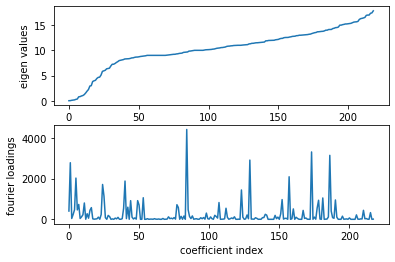

In [43]:
plt.subplot(2,1,1)
plt.plot(eig_val)
plt.ylabel('eigen values')
plt.xlabel('coefficient index')

plt.subplot(2,1,2)
plt.plot(np.power(F_y,2))
plt.ylabel('fourier loadings')
plt.xlabel('coefficient index')

# Experiments 

### calculate TPR and FPR for original 

In [44]:
def test_statistic(eig_val, eig_vec, rho, ALPHA, GAMMA, Y):
    eig_val_intrest = eig_val[1:]
    eig_vector_intrest = eig_vec[:,1:]
    U_transpose_intrest = eig_vector_intrest.T

    G_total = 0
    att_bias = 0 
    H0_val, H1_val = 0,0
    SNR_critical = 0 

    for lambda_count in range(len(eig_val_intrest)):
        lambda_value = eig_val_intrest[lambda_count]

        G_val = (h_function(lambda_value, rho)*(eig_vector_intrest[:,lambda_count].T * Y).item()) * eig_vector_intrest[:,lambda_count]

        att_bias += (h_function(lambda_value, rho))**2

        G_total += G_val

        ## corollary 6 : the GFSS (t_bar) can asymptotically distinguish H0 from H1 if the SNR is stronger than below
        SNR_critical += critial_snr(lambda_value, rho)

        H0_val += H0_calc(lambda_value, rho, alpha = ALPHA)
        H1_val += H1_calc(lambda_value, rho, gamma = GAMMA)


    # L2 norm - this is the t_bar
    attenuated_signal = np.linalg.norm(G_total) - att_bias

    # Fourier transform 
    F_y = U_transpose_intrest*Y

    # cororllary 6 : to fetch mu_sigma ratio 
    omega = neighbour_count
    mu_sigma_ratio = omega*SNR_critical**(1/4)

    #final H0, H1 cal
    H0_final = 2*(np.sqrt(H0_val) + np.log(1/ALPHA))
    H1_final = (1/2)*((mu_sigma_ratio)**2)- 2*(mu_sigma_ratio)*np.sqrt(np.log(2/GAMMA))- 2*(np.sqrt(H1_val))

    # print("The value of T_bar : ", attenuated_signal)
    # print("H0 hypothesis significance : ", H0_final)
    # print("H1 hypothesis significance : ", H1_final)

    return attenuated_signal, H0_final, H1_final

In [45]:
def contaminate(contamination_index, count, overall_count, Y_original=None): 
    if Y_original==None:
        overall_signal = np.random.normal(6.0 ,size=(overall_count,1))
        noise = np.take(overall_signal, contamination_index)
        contaminated_signal =np.ones((count,1))*7 + noise
        np.put(overall_signal, contamination_index, contaminated_signal)
    else:
        noise = np.take(overall_signal, contamination_index)
        overall_signal = Y_original
        np.put(overall_signal, contamination_index, noise)
    return overall_signal

def contaminate_correct(contamination_index, count, overall_count, print_norm=None, without_contamination=False): 
    elevation = 0.47
    x = np.zeros(overall_count)
    
    if not without_contamination:
        for i in range(overall_count):
            if i in contamination_index:
                x[i] = elevation

    # Compute the mean of the signal
    x_bar = np.mean(x)

    # Add Gaussian noise with sigma = 1 to the signal
    x += np.random.normal(scale=1, size=overall_count)

    # Compute the L2 norm of the signal
    l2_norm = np.square(np.linalg.norm(x - x_bar, ord=2))
    mse = np.square(abs(x - x_bar)).mean()
    
    if print_norm:
        print("L2 norm : ", l2_norm)
        print("MSE error : ", mse)
    
    return x.reshape(-1,1)

### Experiment 1 : 112 contaminated wells - close together 

In [46]:
## select the closest wells 
number_contamination_wells = 112

picked_sample = df_NN.sample()

picked_lat = picked_sample.iloc[0].LAT_DD
picked_lon = picked_sample.iloc[0].LON_DD

In [47]:
df_NN['Lat_distance'] = np.square(df_NN.LAT_DD - picked_lat)
df_NN['Lon_distance'] = np.square(df_NN.LON_DD - picked_lon)

In [48]:
contamination_index = df_NN.nsmallest(number_contamination_wells, ['Lat_distance', 'Lon_distance']).index.values

In [49]:
def calulate_rates(output):
    TPR = 0;
    FPR = 0;

    df_output = pd.DataFrame(output, columns=['signal', 'h0', 'h1', 'actual'])
    tn_count = ((df_output.h0 > df_output.signal) & (df_output.actual == 'no')).sum()
    fp_count = ((df_output.h0 <= df_output.signal) & (df_output.actual == 'no')).sum()
    
    fn_count = ((df_output.h1 >= df_output.signal) & (df_output.actual == 'yes')).sum()
    tp_count = ((df_output.h1 < df_output.signal) & (df_output.actual == 'yes')).sum()
    
    tpr = tp_count/(tp_count + fn_count)
    fpr = fp_count/(fp_count + tn_count)

    if np.isnan(tpr):
        TPR=1;
    else:
        TPR=tpr

    if np.isnan(fpr):
        FPR=1
    else:
        FPR=fpr

    return TPR, FPR

In [50]:
loop_count = 200
neighbour_count = 8

output = []

for _ in tqdm(range(loop_count)):
    # Y_generated = contaminate(contamination_index, number_contamination_wells, len(df_y))

    Y_generated = contaminate_correct(contamination_index, number_contamination_wells, len(df_y))
    df_y = pd.DataFrame(Y_generated)

    ## generate the graph 
    Adj = kneighbors_graph(df_y, neighbour_count,  mode='connectivity', include_self=False)
    W = Adj.toarray()
    D = np.diagflat(Adj.sum(axis=1))

    combinatorial_laplacian = D - Adj
    eig_val, eig_vec = np.linalg.eig(combinatorial_laplacian)

    idx = eig_val.argsort()[::1]   
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    rho = eig_val[math.floor(sub_sample_id_count*0.05)] # smallest 96 eigen value 

    ## since kneighbors from scikit learn used a digraph we will always get non symmetric matrix, hence lets force it to and undirected case 
    Adj = Adj + Adj.T
    Adj[Adj > 1] = 1

    attenuated_signal, H0_final, H1_final = test_statistic(eig_val, eig_vec, rho, ALPHA, GAMMA, Y_generated)

    output.append([attenuated_signal, abs(H0_final), abs(H1_final), "yes"])

  0%|          | 0/200 [00:00<?, ?it/s]

In [51]:
calulate_rates(output)

/var/folders/hp/7f70q29n23j1gy07qmhs38v40000gn/T/ipykernel_34026/3591155387.py:13: RuntimeWarning: invalid value encountered in long_scalars
  fpr = fp_count/(fp_count + tn_count)


(0.0, 1)

In [52]:
output

[[15.407174771421374, 15.45391035560564, 62.87694842754223, 'yes'],
 [35.2148695853128, 14.908411513520646, 58.681320456280986, 'yes'],
 [23.34669027738423, 15.295254306088088, 61.653860424926236, 'yes'],
 [23.640828411628576, 15.175658485726599, 60.73339269425624, 'yes'],
 [10.43111492882123, 15.234368548251933, 61.18509085682102, 'yes'],
 [27.7373952647213, 16.081831010698217, 67.73902434980646, 'yes'],
 [27.61346382034177, 15.1051777090301, 60.191553271071484, 'yes'],
 [27.77576789877904, 14.931968886631882, 58.861936518900706, 'yes'],
 [27.158134884600454, 14.780232081131594, 57.69949429515844, 'yes'],
 [15.286946023862736, 15.14643046163799, 60.508638866424434, 'yes'],
 [35.085710728514854, 15.228600052493006, 61.140695748779166, 'yes'],
 [26.778512814913736, 15.410745637025657, 62.54396661657266, 'yes'],
 [27.659567034460657, 15.813106308118218, 65.65416676502417, 'yes'],
 [20.04215912540862, 15.440998258312527, 62.777324434413316, 'yes'],
 [24.566419014851327, 15.342431413644205

In [53]:
def generate_graph(Y_generated, neighbour_count, sub_sample_id_count):  
    df_y = pd.DataFrame(Y_generated)  
    ## generate the graph 
    Adj = kneighbors_graph(df_y, neighbour_count,  mode='connectivity', include_self=False)
    W = Adj.toarray()
    D = np.diagflat(Adj.sum(axis=1))

    combinatorial_laplacian = D - Adj
    eig_val, eig_vec = np.linalg.eig(combinatorial_laplacian)

    idx = eig_val.argsort()[::1]   
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    rho = eig_val[math.floor(sub_sample_id_count*0.05)] # smallest 96 eigen value 

    ## since kneighbors from scikit learn used a digraph we will always get non symmetric matrix, hence lets force it to and undirected case 
    Adj = Adj + Adj.T
    Adj[Adj > 1] = 1

    return eig_val, eig_vec, rho

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
ALPHA_list = np.arange(0.1,1.0,0.1)
GAMMA_list = np.arange(0.1,1.0,0.1)
loop_count = 200

TPR = []
FPR = []

for alpha_val in tqdm(ALPHA_list):
    for gamma_val in GAMMA_list:
        
        output = []
        for contamination_test_case in ['yes', 'no']:
            for _ in range(loop_count):
                if contamination_test_case=='yes':
                    # Y_generated = contaminate(contamination_index, number_contamination_wells, len(df_NN), Y_original=Y)
                    Y_generated = contaminate_correct(contamination_index, number_contamination_wells, len(df_y))
                    
                else:
                    Y_generated = contaminate_correct(contamination_index, number_contamination_wells, len(df_y), without_contamination=True)

                eig_val_generated, eig_vec_generated, rho_generated = generate_graph(Y_generated, neighbour_count, sub_sample_id_count)
                    
                attenuated_signal, H0_final, H1_final = test_statistic(
                                                                        eig_val_generated, eig_vec_generated, rho_generated, 
                                                                        alpha_val, gamma_val, Y_generated
                                                                        )

                output.append([attenuated_signal, abs(H0_final), abs(H1_final), contamination_test_case])
        tpr, fpr = calulate_rates(output)
        TPR.append(tpr);
        FPR.append(fpr);

  0%|          | 0/9 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


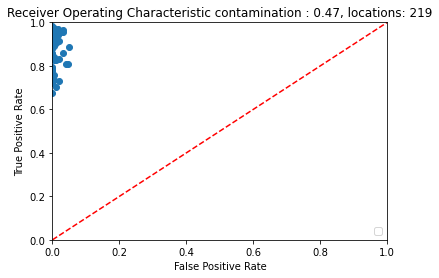

In [56]:
## plot TRP vs FPR

plt.figure; 
plt.title('Receiver Operating Characteristic contamination : 0.47, locations: 219')
plt.scatter(TPR, FPR)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [64]:
ALPHA_list = np.arange(0.1,1.0,0.1)
GAMMA_list = np.arange(0.1,1.0,0.1)
loop_count = 200
number_contamination_wells = 2191

TPR = []
FPR = []

for alpha_val in tqdm(ALPHA_list):
    for gamma_val in GAMMA_list:
        
        output = []
        for contamination_test_case in ['yes', 'no']:
            for _ in range(loop_count):
                if contamination_test_case=='yes':
                    # Y_generated = contaminate(contamination_index, number_contamination_wells, len(df_NN), Y_original=Y)
                    Y_generated = contaminate_correct(contamination_index, number_contamination_wells, len(df_y))
                    
                else:
                    Y_generated = contaminate_correct(contamination_index, number_contamination_wells, len(df_y), without_contamination=True)

                eig_val_generated, eig_vec_generated, rho_generated = generate_graph(Y_generated, neighbour_count, sub_sample_id_count)
                    
                attenuated_signal, H0_final, H1_final = test_statistic(
                                                                        eig_val_generated, eig_vec_generated, rho_generated, 
                                                                        alpha_val, gamma_val, Y_generated
                                                                        )

                output.append([attenuated_signal, abs(H0_final), abs(H1_final), contamination_test_case])
        tpr, fpr = calulate_rates(output)
        TPR.append(tpr);
        FPR.append(fpr);

  0%|          | 0/9 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


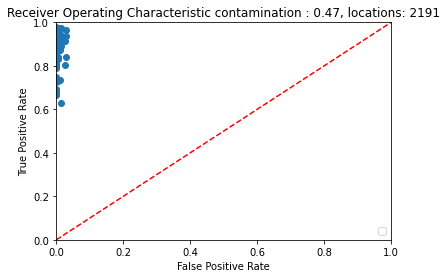

In [65]:
plt.figure; 
plt.title('Receiver Operating Characteristic contamination : 0.47, locations: 2191')
plt.scatter(TPR, FPR)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### test generation of signal

In [57]:
import numpy as np

# Set the level of elevation
elevation = 0.47

n = 112

# wells_belong_to_contaminated_aquifer=[True, True, False]
# wells_belong_to_contaminated_aquifer= np.random.choice(a=[True, False], size=(n, 1), p=[112/n, 1-112/n])
wells_belong_to_contaminated_aquifer= np.ones((n,1))

# Generate a signal with the specified elevation over the wells that belong
# to a contaminated aquifer and zero over the other wells
x = np.zeros(n)
for i in range(n):
  if wells_belong_to_contaminated_aquifer[i]:
    x[i] = elevation

# Compute the mean of the signal
x_bar = np.mean(x)

# Add Gaussian noise with sigma = 1 to the signal
x += np.random.normal(scale=1, size=n)

# Compute the L2 norm of the signal
l2_norm = np.square(np.linalg.norm(x - x_bar, ord=2))

l2_norm_mine = np.sum(np.square(x - x_bar))

mse = np.square(abs(x - x_bar)).mean()

In [58]:
### L2 norm and MSE are not the same 

In [59]:
sum(wells_belong_to_contaminated_aquifer)

array([112.])

In [60]:
mse

1.0468752907147274

In [61]:
l2_norm_mine

117.25003256004948

In [62]:
l2_norm

117.25003256004949

In [63]:
x

array([ 0.46008163,  0.7975387 ,  0.26026008,  1.88827242,  1.52163064,
        1.26146484,  0.63188033,  1.97809743, -0.9081624 ,  0.46267639,
        0.24753372, -1.33875926,  0.36938818,  2.41891534,  1.04990687,
        0.91519241, -1.61118699,  0.62273669,  2.00709974,  0.36028789,
        1.90920033,  0.41625139, -1.44476291,  1.68112904,  0.02729485,
        1.59150562,  1.13628567,  2.17232482,  3.18002417,  1.49928228,
       -0.24713173,  0.74714763, -0.25633398,  0.26537873, -0.81118163,
        1.35760158,  0.55225286,  0.72367128,  2.08177402,  0.0750306 ,
        0.77422937, -0.059476  ,  0.02240786,  1.61550841,  1.12050303,
        1.806217  , -0.09833252,  0.95741967, -1.45499595,  0.43554811,
        0.81420258, -0.63841178,  1.30987631, -0.17973198,  0.703686  ,
        0.78075963,  0.13244947, -1.31187012,  0.4681133 ,  0.59285363,
        1.08064471,  1.33440609, -0.56298848, -0.28402959, -0.39507595,
        1.79638063, -1.80369261,  0.69498979,  1.8721293 , -1.74